In [364]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pyEXP 
import nba
import EXPtools
import gala.potential as gp

In [ ]:
# Declare variables 
#MODEL_NAME = ""
#BASIS_Name = 
#COEFS_NAME = 

# 1. Load halo particles

In [ ]:
halo_particles = np.load('test_halo.npy')
pos = halo_particles[:,1:4]
mass = halo_particles[:,0]

In [367]:
Mtot = np.sum(mass)
print('Mtotal /1e12 Msun: ', Mtot)

Mtotal /1e12 Msun:  0.1576329276249453


(-200.0, 200.0)

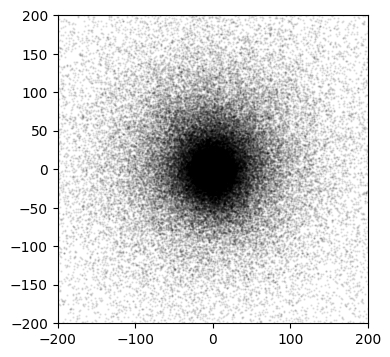

In [540]:
plt.figure(figsize=(4, 4))
plt.scatter(pos[:,0], pos[:,2], s=0.4, alpha=0.1, c='k')
plt.xlim(-200, 200)
plt.ylim(-200, 200)

In [507]:
r = np.linalg.norm(pos, axis=1)
print(len(r))
rencl = np.where(r<=rbins[-1])[0]
print(len(rencl))
Mencl = np.sum(mass[rencl])
print('Menc /1e12 Msun: ', Mencl)

99944
77761
Menc /1e12 Msun:  0.12264562239897714


In [548]:
rshell = np.where((r>50) & (r<250))
pos_shell = pos[rshell]

In [549]:
halo_kin = nba.kinematics.Kinematics(pos_shell, pos_shell)
lgal, bgal = halo_kin.pos_cartesian_to_galactic()

In [553]:
Hdens, lbins, bbins = np.histogram2d(lgal, bgal, bins=(100, 50) ,weights=mass[rshell])

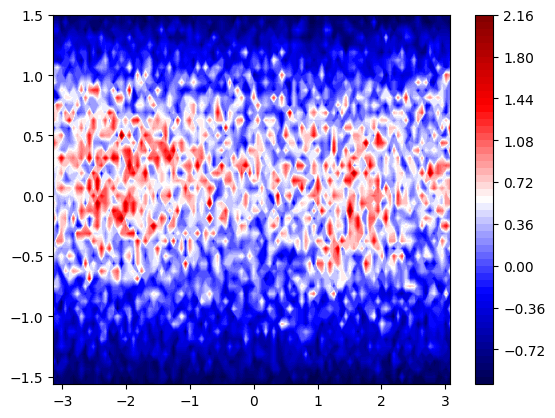

In [574]:
plt.contourf(lbins[:-1], bbins[:-1], Hdens.T/np.mean(Hdens) - 1, 60,  origin='lower',cmap='seismic')
plt.colorbar()

# 2. Compute basis 

## 2.1 Compute density profile

In [577]:
hbins = np.logspace(0, 2.5)
test_halo = nba.structure.Profiles(pos, edges=hbins)
rbins, halo_rho_profile = test_halo.density(mass=mass)
print(len(rbins), len(hbins))


49 50


## 2.2 Compare density profile with fit and model 

In [584]:
Hern_anpot = gp.HernquistPotential(m=Mtot, c=40.85)
grid = np.zeros((3, len(rbins)))
grid[0] = rbins 
Hern_profile = Hern_anpot.density(grid)

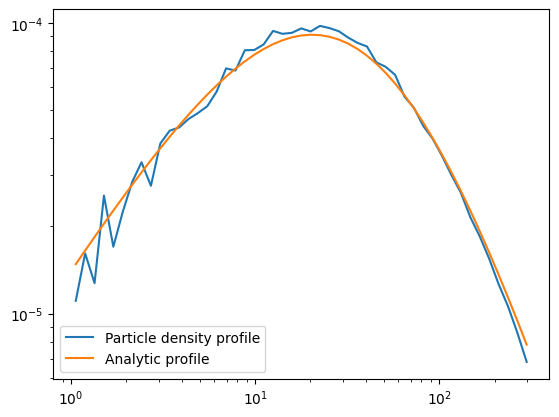

In [585]:
plt.loglog(rbins, rbins**2 * halo_rho_profile, label='Particle density profile')
plt.loglog(rbins, rbins**2 * Hern_profile, label='Analytic profile')
plt.legend()

## 2.3 Compute best fit of density profile 

In [597]:
def fit_twopl(params, radius):
    amplitud = params[0]
    scale_radius = params[1]
    alpha = params[2]
    beta = params[3]
    rc= params[4]

    rho_model = EXPtools.basis_builder.Profiles(radius, 
                                                scale_radius=scale_radius,
                                                alpha=alpha, beta=beta,
                                                amplitud=amplitud)
    return rho_model.power_halo(rc)

fit_params = [0.003, 40.85, 1, 3, 1]
params_guess = [(1e-7, 1e-6), (20, 60.86), (0.9, 1.81), (2, 3.51), (0, 2)]


In [598]:
rho_fit_twopl, fit_params_twopl = EXPtools.basis_builder.make_Dfit(rbins, halo_rho_profile, fit_twopl,
                                                                   params_guess=fit_params, params_bounds=params_guess)

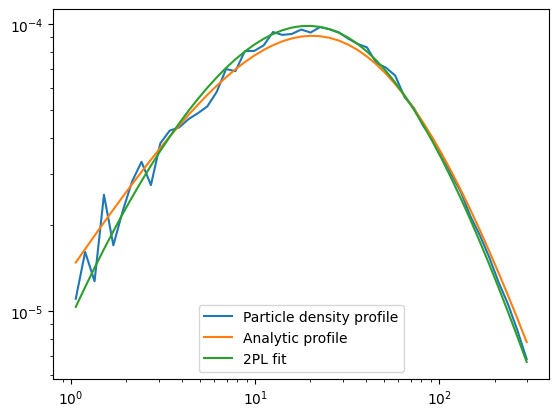

In [599]:
plt.loglog(rbins, rbins**2 * halo_rho_profile, label='Particle density profile')
plt.loglog(rbins, rbins**2 * Hern_profile, label='Analytic profile')
plt.loglog(rbins, rbins**2 * rho_fit_twopl, label='2PL fit')
plt.legend()

In [600]:
print('Best fit params (amplitude, scale length, alpha, beta, rcore): \n', fit_params_twopl)

Best fit params (amplitude, scale length, alpha, beta, rcore): 
 [4.10119224e-07 4.08165698e+01 1.06835637e+00 3.05885399e+00
 1.00387189e+00]


In [604]:
fit_amplitud = fit_params_twopl[0]
print(fit_amplitud)

4.101192240890656e-07


In [615]:
# density profiles differences:
def delta_profiles(profile_fit, profiles):
    log_D0_init = np.log10(np.maximum(profile_fit, 1e-12))
    delta_D = np.zeros_like(profiles)
    nsnaps = len(profiles)
    for d in range(nsnaps):
        log_D_snap = np.log10(np.maximum(profiles[d], 1e-12))
        delta_D[d] = ((log_D0_init - log_D_snap)**2)
    return delta_D

In [616]:
rho_diff = delta_profiles(rho_fit_twopl, [halo_rho_profile])

(-0.001, 0.01)

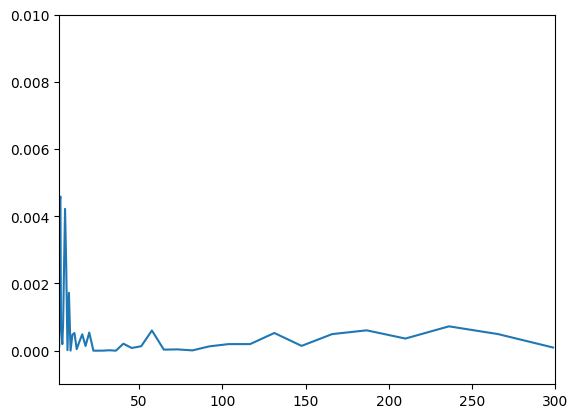

In [617]:
plt.plot(rbins, rho_diff[0])
plt.xlim(2, 300)
plt.ylim(-0.001, 0.01)

In [618]:
rbins_model = np.logspace(-2, 2.5, 500)
rho_fit_model = EXPtools.Profiles(rbins_model, scale_radius=fit_params_twopl[1],
                                               alpha=fit_params_twopl[2], 
                                               beta=fit_params_twopl[3],
                                               amplitud=fit_params_twopl[0])
rho_fit= rho_fit_model.power_halo(fit_params_twopl[4])

In [619]:
model = EXPtools.make_model(rbins_model, rho_fit, Mtotal=Mtot, output_filename='test_MW_GC21_model.txt', physical_units=True)

! Scaling: R = 316.2277660168379  M = 0.1576329276249453
Scaling factors: rfac = 1.0, dfac = 1.0, mfac = 1.0, pfac = 1.0


#### Note that in Mtot we pass the total mass of the halo

In [620]:
R = model['radius']
D = model['density']
M = model['mass']
P = model['potential']

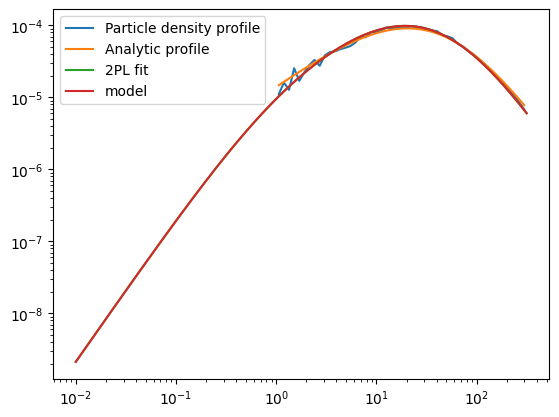

In [621]:
plt.loglog(rbins, rbins**2 * halo_rho_profile, label='Particle density profile')
plt.loglog(rbins, rbins**2 * Hern_profile, label='Analytic profile')
plt.loglog(rbins_model, rbins_model**2*rho_fit, label='2PL fit')
plt.loglog(R, D*R**2, label='model')
plt.legend()

In [684]:
def make_basis(nmax, lmax):
    basis_params = {
    'basis_id' : 'sphereSL',
    'nmax' : nmax, 
    'lmax' : lmax 
    }
    config = EXPtools.make_config(basis_id='sphereSL', 
                              lmax=lmax, nmax=nmax, rmapping=R[-1], modelname='test_MW_GC21_model.txt',
                              cachename='.test_GC21_Spherical_{:03d}'.format(nmax))
    
    basis = pyEXP.basis.Basis.factory(config)
    #EXPtools.write_basis(config, 'test_GC21_DPL_basis_{}_{}.yaml'.format(nmax, lmax))
    return basis

In [685]:
basis_n5 = make_basis(5, 2)
basis_n10 = make_basis(10, 2)
basis_n15 = make_basis(15, 2)
basis_n20 = make_basis(20, 2)

---- SLGridSph::ReadH5Cache: error reading <.test_GC21_Spherical_005>
---- SLGridSph::ReadH5Cache: HDF5 error is <Unable to open file .test_GC21_Spherical_005 (File accessibility) Unable to open file>
---- SLGridSph::ReadH5Cache: error reading <.test_GC21_Spherical_010>
---- SLGridSph::ReadH5Cache: HDF5 error is <Unable to open file .test_GC21_Spherical_010 (File accessibility) Unable to open file>


---- SLGridSph::WriteH5Cache: wrote <.test_GC21_Spherical_005>
---- Spherical::orthoTest: worst=0.00151474
---- SLGridSph::WriteH5Cache: wrote <.test_GC21_Spherical_010>
---- Spherical::orthoTest: worst=0.00566223
---- SLGridSph::WriteH5Cache: wrote <.test_GC21_Spherical_015>


---- SLGridSph::ReadH5Cache: error reading <.test_GC21_Spherical_015>
---- SLGridSph::ReadH5Cache: HDF5 error is <Unable to open file .test_GC21_Spherical_015 (File accessibility) Unable to open file>
---- SLGridSph::ReadH5Cache: 

---- Spherical::orthoTest: worst=0.0146919
---- SLGridSph::WriteH5Cache: wrote <.test_GC21_Spherical_020>
---- Spherical::orthoTest: worst=0.0268159


error reading <.test_GC21_Spherical_020>
---- SLGridSph::ReadH5Cache: HDF5 error is <Unable to open file .test_GC21_Spherical_020 (File accessibility) Unable to open file>


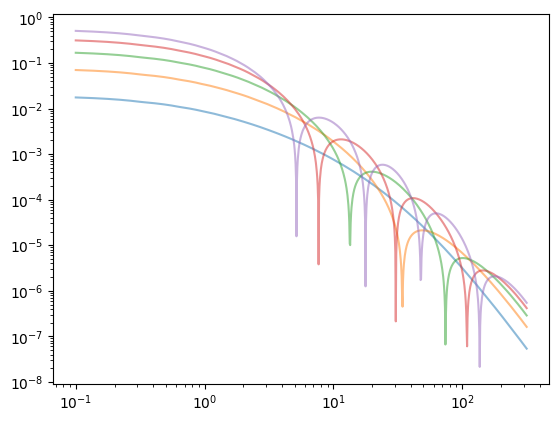

In [686]:
rbasis = np.logspace(-1, 2.5, 1000)
for n in range(0, 5):
    plt.loglog(rbasis, np.abs(basis_n5.getBasis(logxmin=np.log10(rbasis[0]),
                                                 logxmax=np.log10(rbasis[-1]),
                                                 numr=len(rbasis))[0][n]['density']), alpha=0.5)

In [687]:
def create_coefs(basis, mass, pos):
    coef = basis.createFromArray(mass, pos, 0.0)
    coefs = pyEXP.coefs.Coefs.makecoefs(coef, name='halo')
    coefs.add(coef)
    return coefs

In [688]:
coefs_n5 = create_coefs(basis_n5, mass, pos)
coefs_n15 = create_coefs(basis_n15, mass, pos)
coefs_n10 = create_coefs(basis_n10, mass, pos)
coefs_n20 = create_coefs(basis_n20, mass, pos)

In [689]:
print(coefs_n20.Power())

[[2.49152227e-03 1.53058365e-06 3.91309911e-07]]


In [690]:
def spherical_density_profile(basis, coefs, r, npoints=5):
    spherical_grid = EXPtools.visuals.Grid3D('spherical', ranges=[(r,r+0.001), None, None], num_points=npoints)
    xyz_sph = spherical_grid.to('cartesian')
    fields = pyEXP.field.FieldGenerator([0.0], xyz_sph)
    sph_fields = fields.points(basis, coefs)[0.0]['dens m=0']
    sph_fields_all = fields.points(basis, coefs)[0.0]['dens']
    return np.mean(sph_fields), np.mean(sph_fields_all)

In [691]:
field = pyEXP.field.FieldGenerator([0.0], grid.T)
tt = field.points(basis_n5, coefs_n5)[0.0]['dens']

In [692]:
#rbins_bfe = np.logspace(0, 2.5, 49)
rho_mean_sph_n5 = np.zeros_like(rbins)
rho_mean_sph_n10 = np.zeros_like(rbins)
rho_mean_sph_n15 = np.zeros_like(rbins)
rho_mean_sph_n20 = np.zeros_like(rbins)

for r in range(len(rbins)):
    _, rho_mean_sph_n5[r] = spherical_density_profile(basis_n5, coefs_n5,  rbins[r])
    _, rho_mean_sph_n10[r] = spherical_density_profile(basis_n10, coefs_n10, rbins[r])
    _, rho_mean_sph_n15[r] = spherical_density_profile(basis_n15, coefs_n15,  rbins[r])
    _, rho_mean_sph_n20[r] = spherical_density_profile(basis_n20, coefs_n20, rbins[r])
    

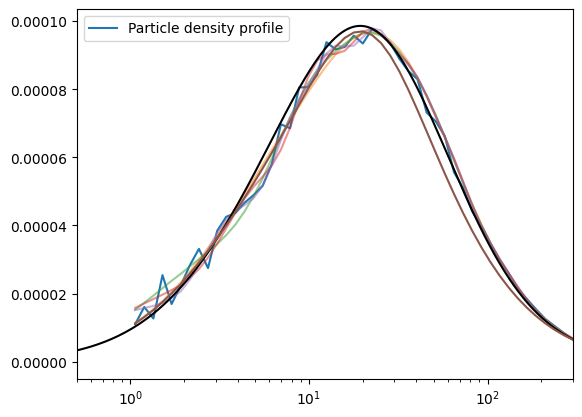

In [693]:
plt.semilogx(rbins, rbins**2 * halo_rho_profile, label='Particle density profile')
plt.semilogx(rbins, rbins**2 * rho_mean_sph_n5, alpha=0.5)
plt.semilogx(rbins, rbins**2 * rho_mean_sph_n10, alpha=0.5)
plt.semilogx(rbins, rbins**2 * rho_mean_sph_n15, alpha=0.5)
plt.semilogx(rbins, rbins**2 * rho_mean_sph_n20, alpha=0.5)
plt.semilogx(R, D*R**2, c='k')
plt.semilogx(rbins, rbins**2 * tt)
plt.xlim(0.5, 300)
plt.legend()

In [694]:
rho_diff_n5 = delta_profiles(rho_mean_sph_n5, [halo_rho_profile])
rho_diff_n10 = delta_profiles(rho_mean_sph_n10, [halo_rho_profile])
rho_diff_n15 = delta_profiles(rho_mean_sph_n15, [halo_rho_profile])
rho_diff_n20 = delta_profiles(rho_mean_sph_n20, [halo_rho_profile])

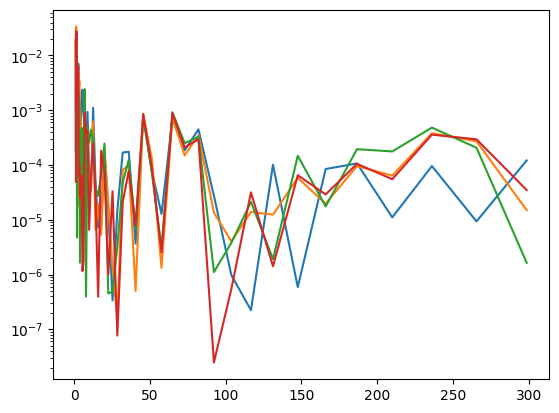

In [695]:
plt.semilogy(rbins, np.abs(rho_diff_n5[0]-halo_rho_profile))
plt.semilogy(rbins, np.abs(rho_diff_n10[0]-halo_rho_profile))
plt.semilogy(rbins, np.abs(rho_diff_n15[0]-halo_rho_profile))
plt.semilogy(rbins, np.abs(rho_diff_n20[0]-halo_rho_profile))
#plt.xlim(5, 300)
#plt.ylim(0, 0.006)